In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import re
import glob
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import cv2

%matplotlib inline

In [13]:
runname = 'WS65_FINAL'
testname = ''

# /home/woody/iwfa/iwfa024h/results2/PA_M/FS0_FINAL_NO_MULTI

In [14]:
with open(f'/home/hpc/iwfa/iwfa024h/Multi_Label_optical_Segmentation/labels/l_to_i.pyb', "rb") as fp:   #Pickling
    label_image_pair = pickle.load(fp)
with open(f'/home/hpc/iwfa/iwfa024h/Multi_Label_optical_Segmentation//labels/i_l.pyb', "rb") as fp:   #Pickling
    image_label_pair = pickle.load(fp)

In [15]:
result_parent_path = '/home/woody/iwfa/iwfa024h/results2/PA_M'

fscore
plot_fscore 

 [[0.1        0.89079609 0.86153199]
 [0.2        0.88701533 0.88002044]
 [0.3        0.88266727 0.86167027]
 [0.4        0.87779449 0.84602111]
 [0.5        0.87207398 0.84416926]
 [0.6        0.86555152 0.83686869]
 [0.7        0.85215866 0.81546417]] 

 plot_ious 

 [[0.1        0.67276689 0.69966522]
 [0.2        0.67276689 0.69966522]
 [0.3        0.67276689 0.69966522]
 [0.4        0.67276689 0.69966522]
 [0.5        0.67276689 0.69966522]
 [0.6        0.67276689 0.69966522]
 [0.7        0.67276689 0.69966522]]
best fscore val:  0.8880471380471381
best fscore test:  0.8864219930396402


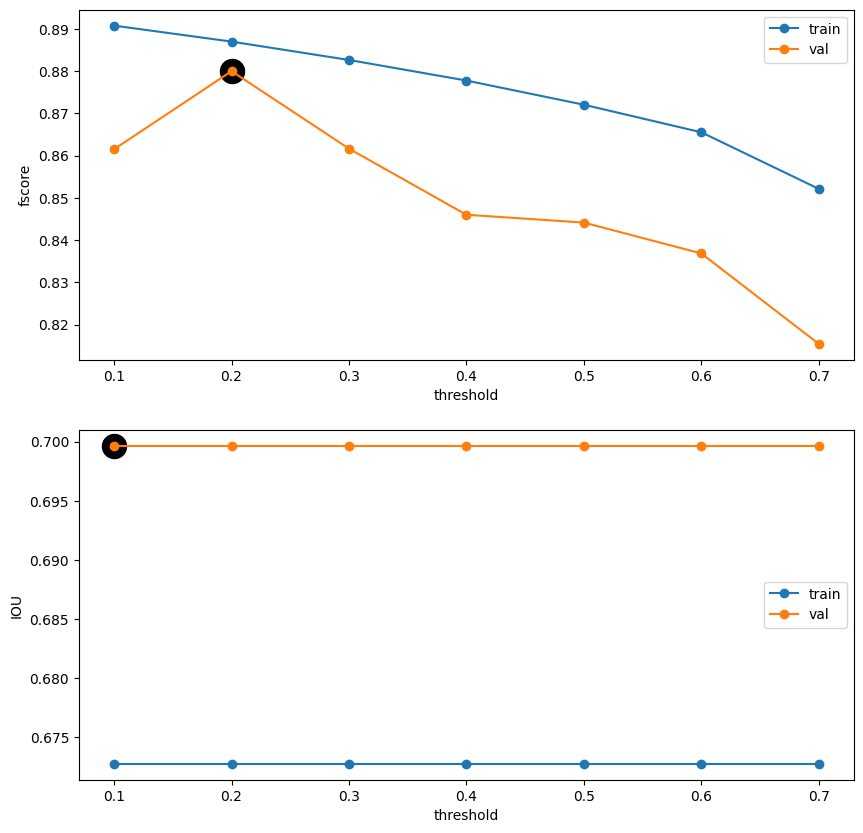

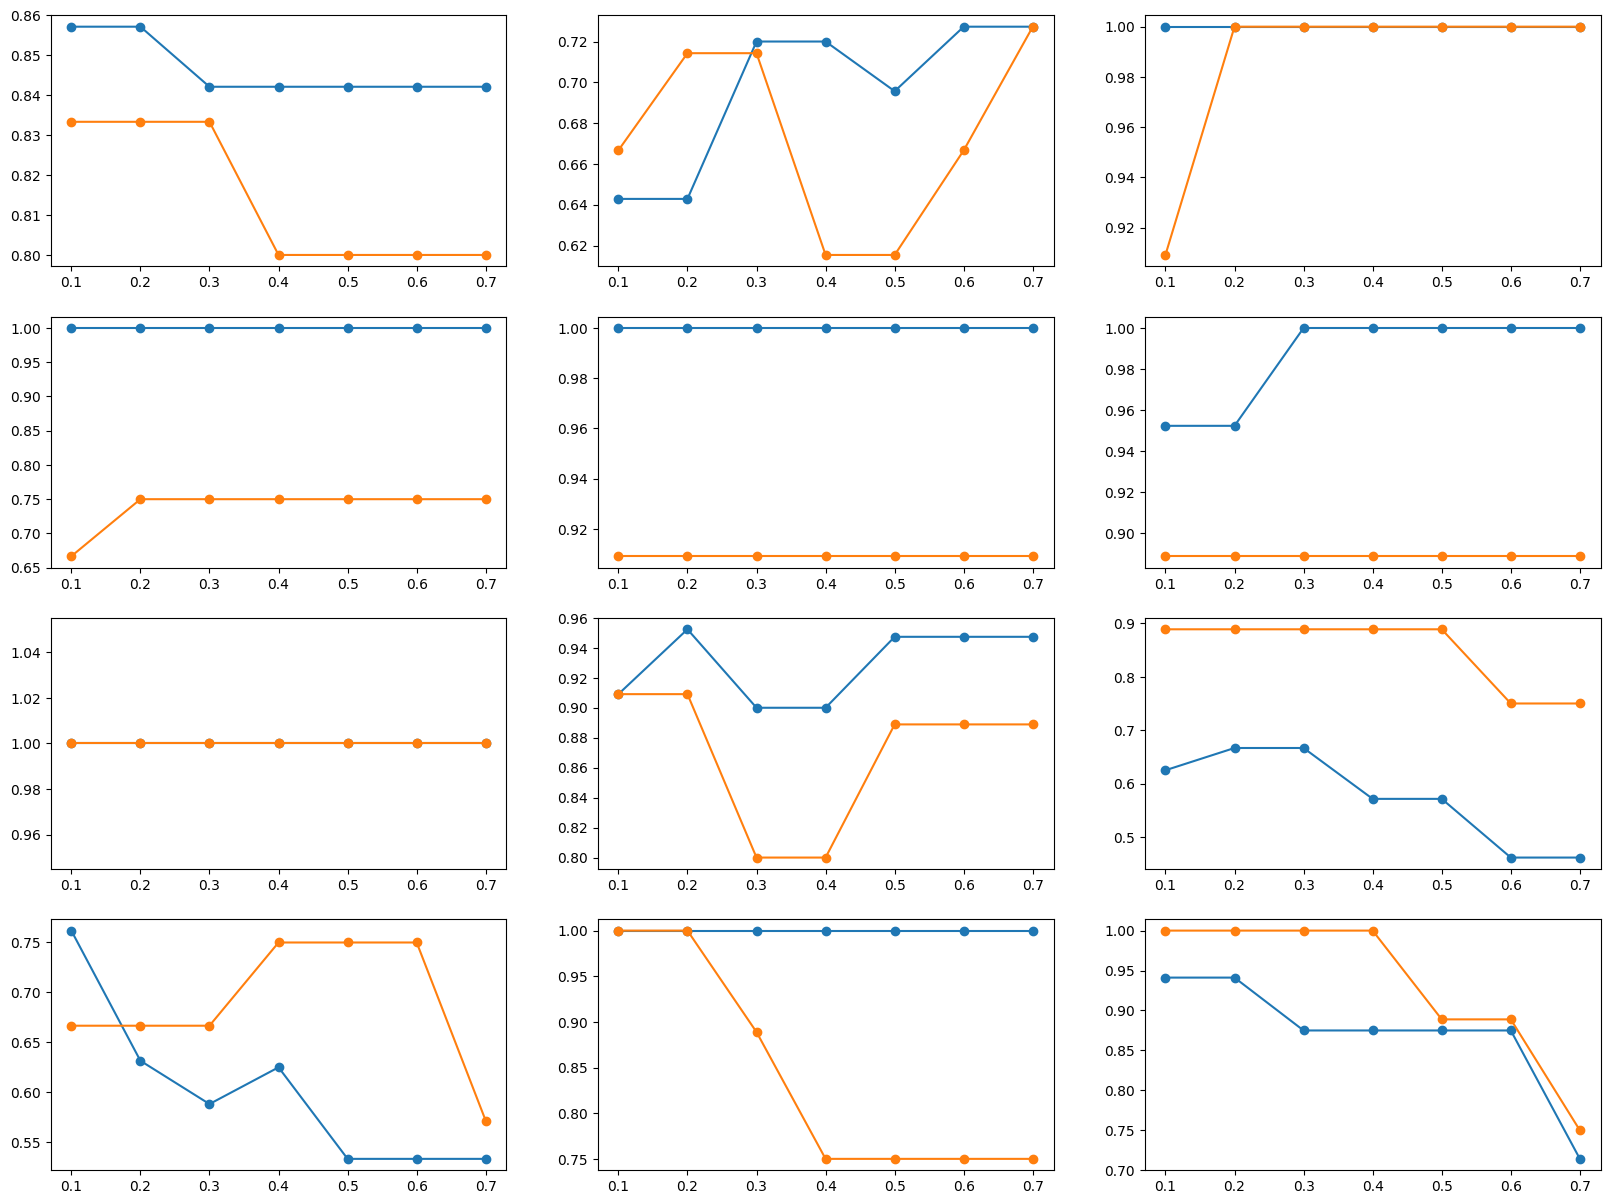

In [16]:
fig,(ax1) = plt.subplots(2,figsize=(10,10))

fig,(axs) = plt.subplots(4,3,figsize=(20,15))
val_f_per_class = []
test_f_per_class = []

# thresholds = np.arange(0.1,0.8,0.1)

# thresholds = [0.1]
test_value = ''

plot_fscore = []
plot_ious = []

metric = 'fscore'
print(metric)

neg_str = "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"
average = 'macro'
# thresh = thresholds[0]
test_resultcsv_path = os.path.join(result_parent_path,runname,f'TEST_results5.0.csv').replace("\\",'/')
val_resultcsv_path = os.path.join(result_parent_path,runname,f'VAL_results5.0.csv').replace("\\",'/')


test_df_result = pd.read_csv(test_resultcsv_path)
val_df_result = pd.read_csv(val_resultcsv_path)

thresholds = np.arange(0.1,0.8,0.1)
i=0
for thresh in np.arange(0.1,0.8,0.1):
    
    ious = val_df_result.IOU_label.apply(lambda x: [float(i) for i in x.split(',')] )
    ground_truth = val_df_result.ground_truth.apply(lambda x: [float(i) for i in x.split(',')] )
    prediction = val_df_result.prediction.apply(lambda x: [float(i) for i in x.split(',')] )
    
    val_ious = np.concatenate([np.atleast_2d(a) for a in np.array(ious)],axis=0)
    val_ground_truth = np.concatenate([np.atleast_2d(a) for a in np.array(ground_truth)],axis=0)
    val_prediction2 = np.concatenate([np.atleast_2d(a) for a in np.array(prediction)],axis=0)
    val_prediction = np.int32(val_prediction2 >= thresh)

    ious = test_df_result.IOU_label.apply(lambda x: [float(i) for i in x.split(',')] )
    ground_truth = test_df_result.ground_truth.apply(lambda x: [float(i) for i in x.split(',')] )
    prediction = test_df_result.prediction.apply(lambda x: [float(i) for i in x.split(',')] )
    
    test_ious = np.concatenate([np.atleast_2d(a) for a in np.array(ious)],axis=0)
    test_ground_truth = np.concatenate([np.atleast_2d(a) for a in np.array(ground_truth)],axis=0)
    test_prediction2 = np.concatenate([np.atleast_2d(a) for a in np.array(prediction)],axis=0)
    test_prediction = np.int32(test_prediction2 >= thresh)

    val_fscore = f1_score(val_ground_truth , val_prediction, average = average)   
    test_fscore = f1_score(test_ground_truth , test_prediction, average = average) 
    
    val_f_per_class.append(f1_score(val_ground_truth , val_prediction, average = None))
    test_f_per_class.append(f1_score(test_ground_truth , test_prediction, average = None))

    plot_fscore.append([thresh,test_fscore,val_fscore])
    plot_ious.append([thresh,test_df_result['IOU'].mean(),val_df_result['IOU'].mean()])
    

val_f_per_class = np.array(val_f_per_class)  
test_f_per_class = np.array(test_f_per_class) 

plot_fscore = np.array(plot_fscore)
plot_ious = np.array(plot_ious)

for i in range(4):
    for j in range(3):
        axs[i][j].plot(thresholds,test_f_per_class.T[i*3+j],label='train'+test_value,marker='o')
        axs[i][j].plot(thresholds,val_f_per_class.T[i*3+j],label='val'+test_value,marker='o')
        

print('plot_fscore','\n\n',plot_fscore, '\n\n','plot_ious','\n\n',plot_ious)

ax1[0].plot(plot_fscore[:,0], plot_fscore[:,1],label='train'+test_value,marker='o')
ax1[0].plot(plot_fscore[:,0], plot_fscore[:,2],label='val'+test_value,marker='o')
val_max = plot_fscore[:,2].max()
val_thresh = plot_fscore[:,2].argmax()
val_thresh = plot_fscore[val_thresh,0]
ax1[0].scatter([val_thresh],[val_max],color='black',s=300)

ax1[1].plot(plot_ious[:,0], plot_ious[:,1],label='train'+test_value,marker='o')
ax1[1].plot(plot_ious[:,0], plot_ious[:,2],label='val'+test_value,marker='o')
val_max = plot_ious[:,2].max()
val_thresh = plot_ious[:,2].argmax()
val_thresh = plot_ious[val_thresh,0]
ax1[1].scatter([val_thresh],[val_max],color='black',s=300)

thresholds[val_f_per_class.argmax(0)]
val_prediction = np.int32(val_prediction2 >= thresholds[val_f_per_class.argmax(0)])
print('best fscore val: ',f1_score(val_ground_truth , val_prediction, average = average) )
test_prediction = np.int32(test_prediction2 >= thresholds[val_f_per_class.argmax(0)])
print('best fscore test: ',f1_score(test_ground_truth , test_prediction, average = average) )
  
ax1[0].legend()
ax1[0].set_xlabel('threshold')
ax1[0].set_ylabel('fscore')

ax1[1].legend()
ax1[1].set_xlabel('threshold')
ax1[1].set_ylabel('IOU')

#     ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
# ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_train'+test_value)
# ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
# ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_train_'+test_value)
# ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

# ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val'+test_value)
# ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
# ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val'+test_value)
# ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

# for c in [0,1]:   
#     ax2[c].legend()
#     ax2[c].set_xlabel('threshold')
#     ax2[c].set_ylabel('count')
#     ax2[c].set_ylim(0,204)
plt.savefig('result.jpg')

In [17]:
val_data = [9, 13, 25, 26, 40, 42, 58, 69, 74, 80, 90, 97, 106, 110, 119, 135, 150, 151, 167, 169, 179, 183, 194, 199, 209, 215, 231, 239, 247, 249, 263, 267, 278, 279, 290, 295, 308, 309, 320, 324, 338, 340, 356, 364, 372, 381, 395, 410, 415, 426, 442, 458, 474, 490, 506, 511, 522, 538, 554, 560, 612, 614, 637, 639, 669, 670, 679, 700, 730, 736, 756, 758, 775, 776, 794, 799, 810, 817, 835, 836, 852, 856, 869, 885, 887, 893, 903, 905, 935, 948, 967, 973, 983, 985, 993, 994]

In [18]:
n_ground = np.hstack([val_ground_truth,np.logical_not( val_ground_truth[:,:2].max(1).reshape(-1,1))])
n_pred = np.hstack([val_prediction,np.logical_not( val_prediction[:,:2].max(1).reshape(-1,1))])
print('best fscore : ',f1_score(n_ground,n_pred, average = average) )
print(thresholds[val_f_per_class.argmax(0)])

best fscore :  0.8962142545957575
[0.1 0.7 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.4 0.1 0.1]


In [19]:
n_ground = np.hstack([test_ground_truth,np.logical_not( test_ground_truth[:,:2].max(1).reshape(-1,1))])
n_pred = np.hstack([test_prediction,np.logical_not( test_prediction[:,:2].max(1).reshape(-1,1))])
print('best fscore : ',f1_score(n_ground,n_pred, average = average) )
print(thresholds[val_f_per_class.argmax(0)])

best fscore :  0.894950299182724
[0.1 0.7 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.4 0.1 0.1]


In [20]:
f1_score(val_ground_truth.max(1),val_prediction.max(1) )

0.9859154929577464

In [ ]:
np.where(np.sum(n_ground == n_pred,axis=1) != 13)[0]

array([124, 163, 164, 167, 169, 183, 185, 189, 190, 192, 195, 196, 200,
       201, 203])

In [30]:
for i in np.where(np.sum(n_ground == n_pred ,axis=1) != 13)[0]:
    print(val_data[i],n_ground[i].astype(int),n_pred[i])

612 [1 0 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 0 0 0 0 0 0 0 0 0 0]
835 [0 0 0 0 0 0 0 0 0 1 0 0 1] [0 0 0 0 0 0 0 0 0 0 0 0 1]
893 [0 1 0 0 1 0 0 0 0 0 0 0 0] [1 1 0 0 1 0 0 0 0 0 0 0 0]
948 [0 1 0 1 1 0 0 0 0 0 0 0 0] [1 1 0 0 0 1 0 0 0 0 0 0 0]
967 [0 0 0 0 0 0 1 0 1 0 1 0 1] [0 0 0 0 0 0 1 0 1 0 0 0 1]
985 [0 1 0 1 1 0 0 0 0 0 0 1 0] [0 1 0 0 1 0 0 0 0 0 0 1 0]


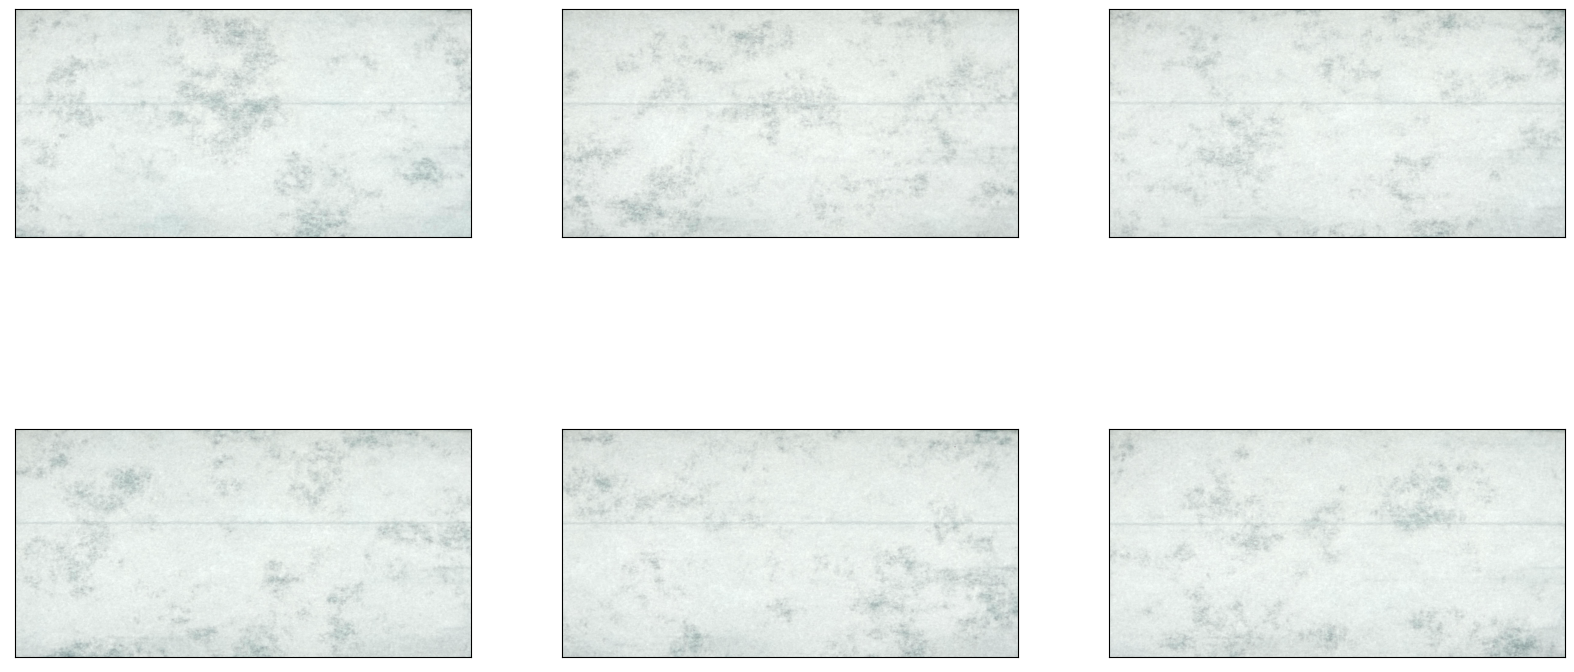

In [14]:
images = []
for i in np.where(np.sum(n_ground == n_pred ,axis=1) != 13)[0]:
    file = f'/home/hpc/iwfa/iwfa024h/dataset/Images_3000x1500/{i}.jpg'
    images.append(cv2.imread(file))  
    
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(6):
    ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])

fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(6):
    ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score,precision_recall_curve, roc_curve, auc,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

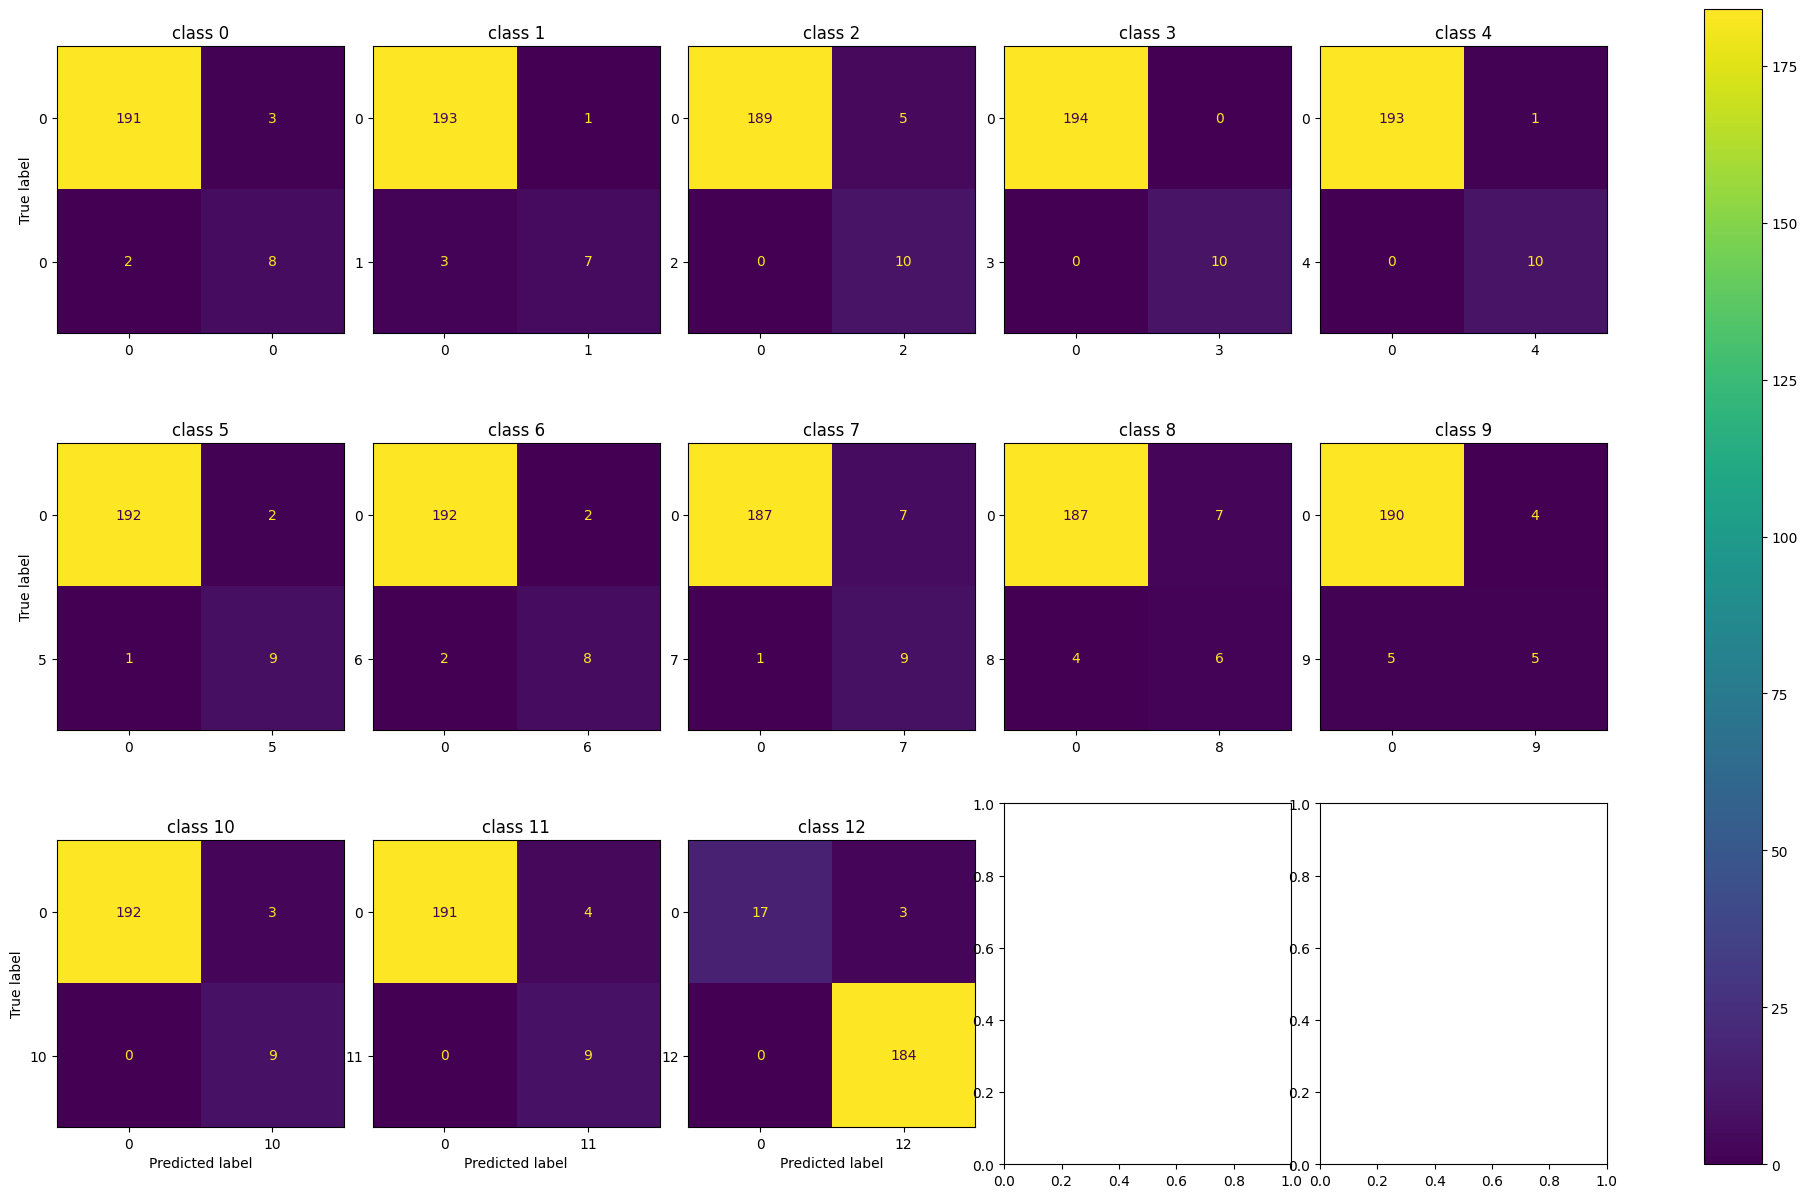

In [40]:
f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(13):
    disp = ConfusionMatrixDisplay(confusion_matrix(n_ground[:, i],
                                                   n_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


([<matplotlib.axis.XTick at 0x7fe9d9e14a60>,
 <a list of 13 Text major ticklabel objects>)

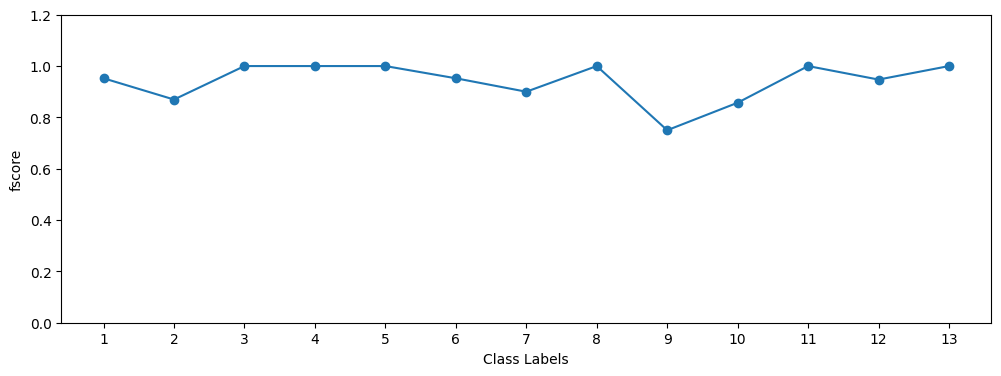

In [15]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(1,14),f1_score(n_ground , n_pred, average = None),marker='o')
plt.xlabel('Class Labels')
plt.ylabel('fscore')
plt.ylim(0,1.2)
plt.xticks(range(1,14))

In [42]:
n_ground.shape

(204, 13)

In [43]:
f1_score(n_ground , n_pred, average = None)

array([0.76190476, 0.77777778, 0.8       , 1.        , 0.95238095,
       0.85714286, 0.8       , 0.69230769, 0.52173913, 0.52631579,
       0.85714286, 0.81818182, 0.99191375])

In [44]:
prediction_matrix = np.zeros((13,13))
for gt,pr in zip(n_ground[:-13],n_pred[:-13]):
# for gt,pr in zip(n_ground,n_pred):
    for j in np.where(pr== 1)[0]:
        prediction_matrix[np.where(gt== 1)[0],j] += 1

In [45]:
prediction_matrix = np.zeros((13,13))
for gt,pr in zip(n_ground[:-13],n_pred[:-13]):
# for gt,pr in zip(n_ground,n_pred):
    for x in np.where(gt == 1)[0]:
        for y in np.where(pr == 1)[0]:
            if x != y:
                if gt[y] == 1:
                    continue
            prediction_matrix[x,y] += 1

In [46]:
prediction_matrix.astype(int)

array([[  8,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  3,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   8,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   4,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   7,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   5,   1,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   4,   1,   2,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   2,   0,   0,   6,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   1,   2,   3,   0,   5,   0],
       [  0,   0,   5,   0,   0,   2,   1,   3,   3,   4,   3,   1, 175]])

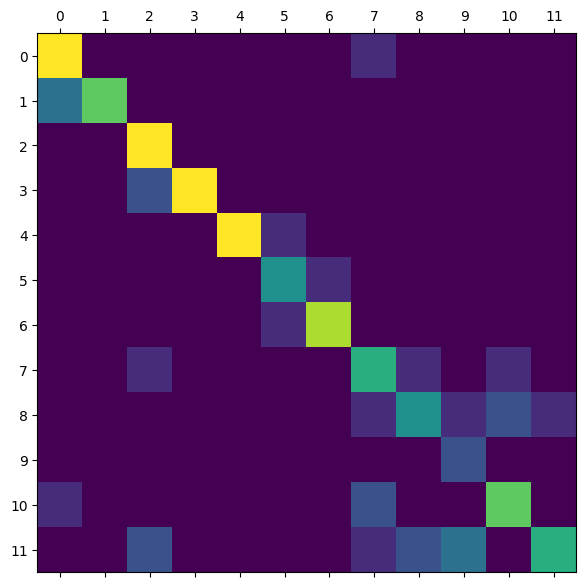

In [47]:

# fig  = plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.matshow(prediction_matrix[:-1,:-1])
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
plt.show()

In [48]:
prediction_matrix.astype(int)

array([[  8,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  3,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   8,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   4,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   7,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   5,   1,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   4,   1,   2,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   2,   0,   0,   6,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   1,   2,   3,   0,   5,   0],
       [  0,   0,   5,   0,   0,   2,   1,   3,   3,   4,   3,   1, 175]])

In [49]:
prediction_matrix[np.where(gt== 1)[0],np.where(pr== 1)[0]]

array([  8.,   4., 175.])

In [50]:
np.where(gt== 1)[0].shape

(3,)

In [51]:
prediction_matrix[[1,2],[3,4,5]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (3,) 

In [52]:
prediction_matrix[np.where(gt== 1)[0],[9,11,12]]

array([  0.,   1., 175.])

In [53]:
prediction_matrix[np.where(gt== 1)[0],[0,1]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (2,) 

In [56]:
prediction_matrix[np.where(gt== 1)[0]]

array([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]])

In [57]:
prediction_matrix

array([[3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [310]:
precision_recall_curve(y_true=n_ground.reshape(-1),n_pred.reshape(-1))

SyntaxError: positional argument follows keyword argument (<ipython-input-310-ea0b1a4c7963>, line 1)

In [311]:
precision = precision_score(n_ground, n_pred, average=None)
precision

array([0.83333333, 0.75      , 1.        , 1.        , 1.        ,
       0.8       , 1.        , 1.        , 0.8       , 1.        ,
       1.        , 1.        , 0.98850575])

In [312]:
recall = recall_score(n_ground, n_pred, average=None)
recall

array([1.        , 0.6       , 1.        , 0.6       , 0.83333333,
       1.        , 1.        , 0.8       , 0.8       , 1.        ,
       0.8       , 1.        , 1.        ])

In [313]:
classification_report(y_expected, y_pred)

NameError: name 'y_expected' is not defined

In [314]:
print('best fscore : ',f1_score(val_ground_truth.max(1) , val_prediction.max(1)) )

best fscore :  1.0


In [315]:
val_ground_truth.max(1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [316]:
val_prediction.max(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [317]:
import sklearn.metrics.classifiction_report

classification_report(
    val_ground_truth,
    val_prediction,
    output_dict=False,
)

ModuleNotFoundError: No module named 'sklearn.metrics.classifiction_report'

In [342]:
n2_ground = n_ground
n2_pred = n_pred

In [343]:


fscores_all = []
thresholds_all = []

for i in range(12):
    
    n_pred = n2_pred[:,i]
    n_ground = n2_ground[:,i]
    
    metrics = {}
    labels = n_ground.ravel()
    predictions = n_pred.ravel()
    precision, recall, thresholds = precision_recall_curve(n_ground.ravel(),n_pred.ravel())
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['thresholds'] = thresholds
    f_measures = 2 * np.multiply(recall, precision) / (recall + precision + 1e-8)
    metrics['f_measures'] = f_measures
    ix_best = np.argmax(f_measures)
    metrics['ix_best'] = ix_best
    best_f_measure = f_measures[ix_best]
    metrics['best_f_measure'] = best_f_measure
    best_thr = thresholds[ix_best]
    metrics['best_thr'] = best_thr
    FPR, TPR, _ = roc_curve(labels, predictions)
    metrics['FPR'] = FPR
    metrics['TPR'] = TPR
    AUC = auc(FPR, TPR)
    metrics['AUC'] = AUC
    AP = auc(recall, precision)
    metrics['AP'] = AP
    decisions = predictions >= best_thr
    metrics['decisions'] = decisions
    
    thresholds_all.append(best_thr)
    fscores_all.append(best_f_measure)
# # FP, FN, TN, TP = calc_confusion_mat(decisions, labels)
# metrics['FP'] = FP
# metrics['FN'] = FN
# metrics['TN'] = TN
# metrics['TP'] = TP
# metrics['accuracy'] = (sum(TP) + sum(TN)) / (sum(TP) + sum(TN) + sum(FP) + sum(FN))

IndexError: too many indices for array

In [341]:
thresholds_all

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [324]:
fscores_all

[0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995,
 0.999999995]

In [322]:
np.mean(fscores_all)

0.9999999949999999

In [319]:
metrics

{'precision': array([0.11698718, 0.96503497, 1.        ]),
 'recall': array([1.        , 0.94520548, 0.        ]),
 'thresholds': array([0, 1], dtype=int32),
 'f_measures': array([0.20946915, 0.9550173 , 0.        ]),
 'ix_best': 1,
 'best_f_measure': 0.9550172960386011,
 'best_thr': 1,
 'FPR': array([0.        , 0.00453721, 1.        ]),
 'TPR': array([0.        , 0.94520548, 1.        ]),
 'AUC': 0.9703341371851927,
 'AP': 0.9583253504486381,
 'decisions': array([False, False, False, ..., False,  True,  True])}

In [292]:
AP

0.8515386643946771

In [196]:
np.concatenate(val_prediction,axis=0).shape

(1152,)

In [ ]:
fscore(val_ground_truth)

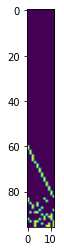

In [8]:
plt.imshow(val_ground_truth)

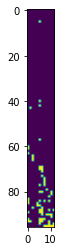

In [11]:
plt.imshow(val_prediction2>0.1)

0.8875114784205693
[0.90909091 0.66666667 1.         0.75       0.90909091 0.88888889
 1.         0.88888889 1.         0.75       1.        ]


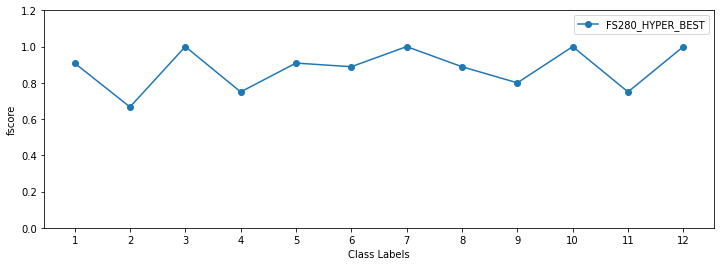

In [328]:
threshold = [0.7]
# threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
# runnames = ['FS280_DATASET1']*len(threshold)
runnames = ['FS280_HYPER_BEST']
testname = ''
seg_sizes = [12]*len(threshold)

# threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
# colors = ['red','blue']

# runnames = ['FS280_NO_WEGLOSS']
# testname = ''

# threshold = [0.1]
# colors = ['red']


plt.figure(figsize=(12,4))
avg_fscore = []

for runname, thresh, seg_size in zip(runnames,threshold,seg_sizes):

    train_resultcsv_path = os.path.join(result_parent_path,runname,f'TRAIN_results{thresh*10}.csv').replace("\\",'/')
    val_resultcsv_path = os.path.join(result_parent_path,runname,f'VAL_results{thresh*10}.csv').replace("\\",'/')


    # train_df_result = pd.read_csv(train_resultcsv_path)
    
    val_df_result = pd.read_csv(val_resultcsv_path)
    img_names = val_df_result.img_name.values
    ious = val_df_result.IOU_label.apply(lambda x: [float(i) for i in x.split(',')] ).values
    ground_truth = val_df_result.ground_truth.apply(lambda x: [float(i) for i in x.split(',')] ).values
#     ious_neg = val_df_result[:60].IOU_label.apply(lambda x: [float(i) for i in x.split(',')] )
    prediction = val_df_result.prediction.apply(lambda x: [float(i) for i in x.split(',')] ).values
    
    ious = np.concatenate([np.atleast_2d(a) for a in np.array(ious)],axis=0)
#     ious_neg = np.concatenate([np.atleast_2d(a) for a in np.array(ious_neg)],axis=0)
    ground_truth = np.concatenate([np.atleast_2d(a) for a in np.array(ground_truth)],axis=0)
    prediction_r = np.concatenate([np.atleast_2d(a) for a in np.array(prediction)],axis=0)
    
    
#     avg_fscore.append(val_df_result.fscore.mean())
    
    if runname  == 'FS280_DATASET2' :
        ious_mean = np.append([0],ious.mean(0))
        print('here')
    else:
        ious_mean = ious.mean(0)
    
    
#     print(ious_mean.shape)
#     plt.plot(np.arange(1,seg_size+1),f1_score(ground_truth , prediction, average = None),'-o',c = color,label = runname)
    prediction = np.int32(prediction_r > thresh)
#     print(prediction)
    plt.plot(np.arange(1,seg_size+1),f1_score(ground_truth , prediction, average = None),label = f'{runname}',marker='o')
#     plt.plot(np.arange(1,seg_size),f1_score(np.delete(ground_truth,8,axis=1) , np.delete(prediction,8,axis=1), average = None),label = f'{runname}_{thresh}',marker='o')
#     plt.plot(np.arange(1,12),ious_mean,'-o',label = f'{runname}_{thresh}')
    #     plt.scatter(i,np.mean(counts_neg[i]),c = 'green')
    print(f1_score(np.delete(ground_truth,8,axis=1) , np.delete(prediction,8,axis=1), average = 'macro'))
    print(f1_score(np.delete(ground_truth,8,axis=1) , np.delete(prediction,8,axis=1), average = None))
    
plt.xlabel('Class Labels')
plt.ylabel('fscore')
plt.ylim(0,1.2)
plt.xticks(range(1,seg_size+1))


plt.legend()
# print('iou',ious.mean(0))
    

In [416]:
np.delete(prediction,9,axis=1).shape

(96, 11)

In [143]:
ground_truth[:,1].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [145]:
(prediction_r[:,1] > 0).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [115]:
prediction[:,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.4 , 0.  , 0.1 , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.74, 0.03, 0.  , 0.  ,
       0.  , 0.85, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ])

In [132]:
(prediction_r[:,0]>0 ).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0])

In [113]:
ground_truth[:,0].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0])

In [133]:
(prediction_r[:,0]>thresh ).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [137]:
prediction[:,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [146]:
img_names[prediction[:,0] != ground_truth[:,0].astype(int)]

array([611, 609, 619, 625, 604, 984, 613, 601, 945, 606, 607, 886, 946,
       623, 603, 981, 629, 883, 630, 944, 982, 616, 889, 610, 620, 624,
       898, 881, 617, 627])

In [149]:
img_names[(prediction_r[:,0] > 0).astype(int) != ground_truth[:,0].astype(int)]

array([611, 899, 984, 642, 643, 891, 988, 607, 894, 946, 623, 655, 883,
       636, 641, 896, 952, 640, 897, 944, 982, 949, 620, 947, 638, 624,
       898, 881, 892])

In [140]:
prediction_r[prediction[:,0] != ground_truth[:,0].astype(int)][:,0]

array([0.01, 0.02, 0.85, 0.02])

In [134]:
(prediction_r[:,0]>0 ).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0])

In [141]:
img_names[ground_truth[:,0].astype(int) == 1]

array([612, 614, 885, 887, 983])

In [1230]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth , prediction))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.83      0.91         6
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       0.80      0.80      0.80         5
          10       1.00      0.40      0.57         5
          11       1.00      1.00      1.00         5

   micro avg       0.87      0.88      0.88        60
   macro avg       0.89      0.89      0.87        60
weighted avg       0.90      0.88      0.87        60
 samples avg       0.35      0.35      0.35        60



/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'/home/woody/iwfa/iwfa024h/results2/PA_M/FS280_Test/VAL_results7.0.csv'

In [997]:
def gen_y_vals(img_names,del_axis = None):
    
    global image_label_pair
    
    labels_trained = []
    for i in img_names:
        labels_trained.append([int(l) for l in image_label_pair[i]])
    X,y = np.array(img_names).reshape(-1,1),labels_trained
#     print(X,y)
    one_hot = MultiLabelBinarizer(classes =np.arange(1,14))
    y_vals = one_hot.fit_transform(y)
    if del_axis is not None:
        y_vals=np.delete(y_vals,del_axis,axis = 1)
    return y_vals
   

In [ ]:
train_data =  [1, 2, 3, 5, 6, 8, 11, 12, 14, 16, 17, 18, 19, 21, 22, 24, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 41, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 70, 72, 73, 75, 76, 78, 79, 81, 82, 83, 85, 86, 88, 89, 91, 92, 94, 95, 96, 98, 99, 101, 102, 104, 105, 107, 108, 111, 112, 113, 114, 115, 117, 120, 121, 123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 144, 145, 146, 147, 149, 152, 153, 155, 156, 158, 159, 160, 161, 162, 163, 165, 166, 168, 171, 172, 174, 175, 176, 177, 178, 181, 182, 184, 185, 187, 188, 190, 191, 192, 193, 195, 197, 198, 200, 201, 203, 204, 206, 207, 208, 210, 211, 213, 214, 216, 217, 219, 220, 222, 223, 224, 225, 226, 227, 229, 230, 232, 233, 235, 236, 238, 240, 241, 242, 243, 245, 246, 248, 251, 252, 254, 255, 256, 257, 258, 259, 261, 262, 264, 265, 268, 270, 271, 272, 273, 274, 275, 277, 280, 281, 283, 284, 286, 287, 288, 289, 291, 293, 294, 296, 299, 300, 302, 303, 304, 305, 306, 307, 310, 312, 313, 315, 316, 318, 319, 321, 322, 323, 325, 326, 328, 329, 331, 332, 334, 335, 336, 337, 339, 341, 342, 344, 345, 347, 348, 350, 351, 352, 353, 354, 355, 357, 358, 360, 361, 363, 366, 367, 368, 369, 370, 371, 373, 374, 376, 377, 380, 382, 383, 384, 385, 386, 387, 389, 390, 392, 393, 396, 398, 399, 400, 401, 402, 403, 405, 406, 408, 409, 411, 412, 414, 416, 417, 418, 419, 421, 422, 424, 425, 427, 428, 430, 431, 432, 433, 434, 435, 437, 438, 440, 441, 443, 444, 446, 447, 448, 449, 450, 451, 453, 454, 456, 457, 459, 460, 462, 463, 464, 465, 466, 467, 469, 470, 472, 473, 475, 476, 478, 479, 480, 481, 482, 483, 485, 486, 488, 489, 491, 492, 494, 495, 496, 497, 498, 499, 501, 502, 504, 505, 507, 508, 510, 512, 513, 514, 515, 517, 518, 520, 521, 523, 524, 526, 527, 528, 529, 530, 531, 533, 534, 536, 537, 539, 540, 542, 543, 544, 545, 546, 547, 549, 550, 552, 553, 555, 558, 559, 561, 562, 563, 565, 566, 568, 569, 571, 572, 574, 575, 576, 577, 578, 579, 581, 582, 584, 585, 587, 588, 590, 591, 592, 593, 594, 595, 597, 598, 600, 601, 603, 604, 606, 607, 608, 609, 610, 611, 613, 616, 617, 619, 620, 622, 623, 624, 625, 626, 627, 629, 630, 632, 633, 635, 636, 638, 640, 641, 642, 643, 645, 646, 648, 649, 651, 652, 654, 655, 656, 657, 658, 659, 661, 662, 664, 665, 667, 668, 671, 672, 673, 674, 675, 678, 680, 681, 683, 684, 686, 687, 688, 689, 690, 691, 693, 694, 696, 697, 699, 702, 703, 704, 705, 706, 707, 709, 710, 712, 713, 715, 716, 718, 719, 720, 721, 722, 723, 725, 726, 728, 729, 731, 734, 735, 737, 738, 739, 741, 742, 744, 745, 747, 748, 750, 751, 752, 753, 754, 755, 757, 760, 761, 763, 764, 766, 767, 768, 769, 770, 773, 774, 777, 779, 780, 782, 783, 784, 785, 786, 787, 789, 790, 792, 793, 796, 798, 800, 801, 802, 805, 806, 808, 809, 811, 812, 814, 815, 816, 818, 819, 821, 822, 824, 825, 827, 828, 830, 831, 832, 833, 834, 837, 838, 840, 841, 843, 844, 846, 847, 848, 849, 850, 851, 853, 854, 855, 857, 859, 860, 862, 863, 864, 865, 866, 867, 870, 871, 872, 875, 876, 878, 879, 880, 881, 882, 883, 886, 888, 889, 891, 892, 894, 895, 896, 897, 898, 899, 901, 902, 904, 907, 908, 910, 911, 912, 913, 914, 915, 917, 918, 920, 921, 923, 924, 926, 927, 928, 929, 930, 931, 933, 934, 936, 937, 939, 940, 942, 944, 945, 946, 947, 949, 950, 952, 953, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 968, 969, 971, 972, 974, 975, 976, 977, 978, 979, 981, 982, 984, 987, 988, 990, 991, 992, 995, 997, 998, 1000]

In [971]:
val_data = [9, 13, 25, 26, 40, 42, 58, 69, 74, 80, 90, 97, 106, 110, 119, 135, 150, 151, 167, 169, 179, 183, 194, 199, 209, 215, 231, 239, 247, 249, 263, 267, 278, 279, 290, 295, 308, 309, 320, 324, 338, 340, 356, 364, 372, 381, 395, 410, 415, 426, 442, 458, 474, 490, 506, 511, 522, 538, 554, 560, 612, 614, 637, 639, 669, 670, 679, 700, 730, 736, 756, 758, 775, 776, 794, 799, 810, 817, 835, 836, 852, 856, 869, 885, 887, 893, 903, 905, 935, 948, 967, 973, 983, 985, 993, 994]

In [1000]:
val_data = np.array(val_data)
val_y_vals = gen_y_vals(val_data)
prediction = np.insert(prediction, 0, values=0, axis=1)
prediction[:,0] = np.int32(np.logical_not((prediction[:,1])|(prediction[:,2])|(prediction[:,3]) )) 

In [1001]:
print(f1_score(val_y_vals , prediction, average = 'weighted'))

0.9027777777777778


(0.0, 1.2)

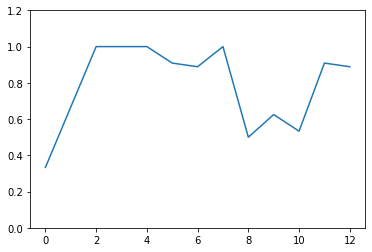

In [1002]:
plt.plot(np.arange(13),f1_score(val_y_vals , prediction, average = None))
plt.ylim(0,1.2)

In [935]:
ground_truth[(val_df_result.img_name >= 600)&(val_df_result.img_name <= 630) ] 

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [936]:
prediction

,prediction,IOU,IOU_label,ground_truth,fscore,img_name
60,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",8.333333e-08,"0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0","0,0,0,0,0,0,0,0,0,0,0,0",0.956522,612
61,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",3.333332e-07,"0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0","0,0,0,0,0,0,0,0,0,0,0,0",0.956522,614


In [838]:
ious.mean(0)

array([0.931875  , 0.57083333, 0.98708333, 0.9515625 , 0.9659375 ,
       0.97083333, 0.979375  , 0.93479167, 0.94864583, 0.92010417,
       0.95114583, 0.95145833])

In [677]:
f1_score(ground_truth , prediction, average = 'samples',zero_division = 1)

0.9239914021164021

In [674]:
f1_score(ground_truth , prediction, average = 'samples',zero_division = 1)

0.9328124999999999

In [647]:
counts = dict.fromkeys(np.arange(1,13,dtype = int),[])
counts_neg = dict.fromkeys(np.arange(1,13,dtype = int),[])

In [649]:
f1_score(ground_truth , prediction, average = None)

array([0.83333333, 0.54545455, 1.        , 0.75      , 0.90909091,
       0.8       , 0.8       , 0.90909091, 0.76923077, 0.57142857,
       0.75      , 0.90909091])

In [853]:
idx = ground_truth[:,0] == 1
np.mean(prediction[idx] == ground_truth[idx])

0.9076923076923077

In [866]:

for i in range(1,13):
    counts[i] = ious[:,i-1][ground_truth[:,i-1] == 1]
counts

{1: array([0.62, 0.63, 0.48, 0.47, 0.36]),
 2: array([0.14, 0.27, 0.  , 0.  , 0.  ]),
 3: array([0.26, 0.42, 0.65, 0.58, 0.65, 0.67, 0.71, 0.75, 0.64, 0.64, 0.66,
        0.67, 0.98, 0.89, 0.65, 0.79, 0.55, 0.87, 0.33, 0.47, 0.6 , 0.77,
        0.65, 0.6 , 0.6 , 0.45, 0.47, 0.94, 0.82, 0.64, 0.7 , 0.66, 0.66,
        0.44, 0.89, 0.53, 0.57, 0.64, 0.65, 0.95, 0.48, 0.66, 0.69, 0.69,
        0.32, 0.67, 0.72, 0.36, 0.63, 0.79, 0.42, 0.26, 0.57, 0.61, 0.73,
        0.64, 0.66, 0.77, 0.66, 0.5 , 0.32, 0.54, 0.81, 0.24, 0.34, 0.48,
        0.59, 0.3 , 0.34, 0.16, 0.36, 0.87, 0.8 , 0.49, 0.3 , 0.21, 0.25,
        0.53, 0.32, 0.13, 0.13]),
 4: array([0.8 , 0.99, 0.73, 0.63, 0.64]),
 5: array([0.02, 0.  , 0.  , 0.02, 0.16]),
 6: array([0.38, 0.49, 0.65, 0.57, 0.  , 0.61]),
 7: array([0.54, 0.5 , 0.57, 0.56]),
 8: array([0.46, 0.69, 0.63, 0.66, 0.54]),
 9: array([0.16, 0.22, 0.28, 0.03, 0.21]),
 10: array([0.  , 0.  , 0.04, 0.  , 0.  ]),
 11: array([0.01, 0.02, 0.3 , 0.05, 0.  ]),
 12: array([0

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False,  True, False,
         True,  True, False, False,  True,  True])]

In [862]:
ious[:,2]

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.76, 0.99,
       0.74, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.65, 0.62,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

/home/hpc/iwfa/iwfa024h/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hpc/iwfa/iwfa024h/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([<matplotlib.axis.XTick at 0x7f24312fc0a0>,
 <a list of 11 Text major ticklabel objects>)

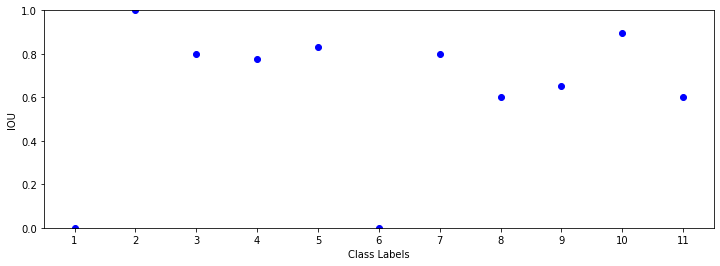

In [580]:
plt.figure(figsize=(12,4))
# plt.scatter(np.arange(1,13),np.mean(ious,0),c = 'red')
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'blue')
#     plt.scatter(i,np.mean(counts_neg[i]),c = 'green')
plt.xlabel('Class Labels')
plt.ylabel('IOU')
plt.ylim(0,1)
plt.xticks(range(1,12))

In [581]:
pos_ious = []
for i in counts.keys():
    pos_ious = np.append(pos_ious,counts[i])

In [582]:
pos_ious.mean()

0.6474545454545454

(0.0, 1.0)

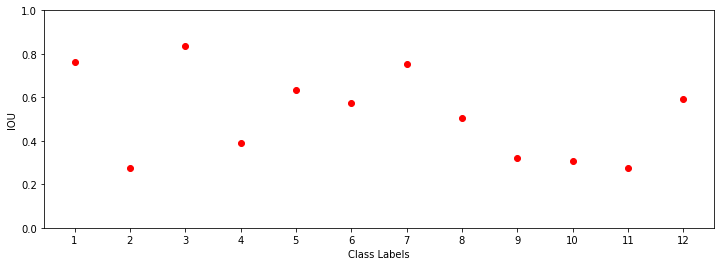

In [533]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
plt.xlabel('Class Labels')
plt.ylabel('IOU')
plt.xticks(range(1,13))
plt.ylim(0,1)

In [929]:
np.insert(np.arange(9).reshape(3,3), 3, values=1, axis=1)

array([[0, 1, 2, 1],
       [3, 4, 5, 1],
       [6, 7, 8, 1]])

(0.0, 1.0)

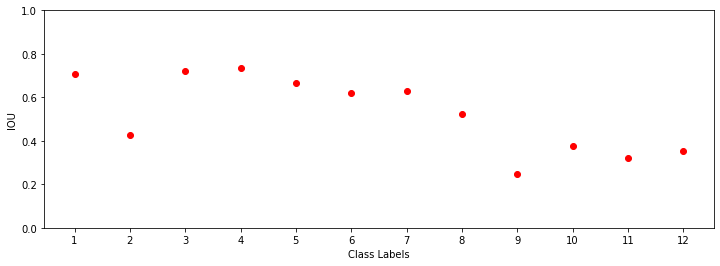

In [329]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
    plt.scatter(i,np.mean(counts[i]),c = 'blue')
plt.xlabel('Class Labels')
plt.ylabel('IOU')
plt.xticks(range(1,13))
plt.ylim(0,1)

(0.0, 1.0)

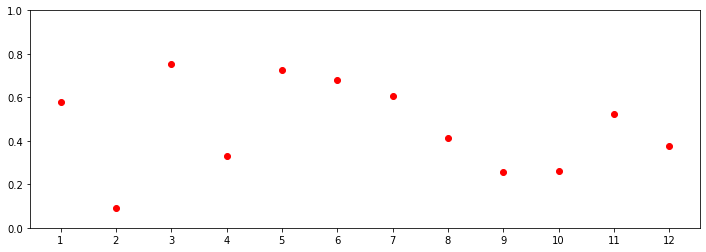

In [316]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
plt.xticks(range(1,13))
plt.ylim(0,1)

In [ ]:
val_df_result[val_df_result.img_name == ]

(0.0, 1.0)

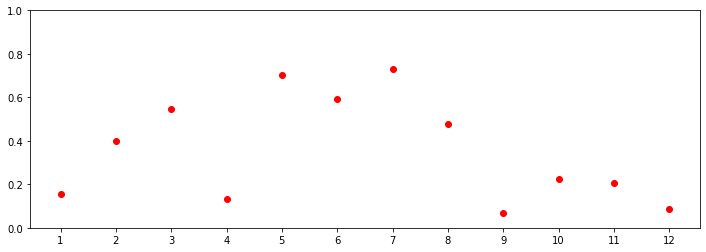

In [264]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
plt.xticks(range(1,13))
plt.ylim(0,1)

In [308]:
test_df_result[test_df_result.img_name == 634]

,prediction,IOU,ground_truth,fscore,img_name
127,"0.85,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0","0,1,0,0,0,0,0,0,0,0,0,0",0.928571,634


In [181]:
np.sort(label_image_pair['1'])

array([601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
       627, 628, 629, 630, 881, 882, 883, 884, 885, 886, 887, 888, 889,
       890, 941, 942, 943, 944, 945, 946, 981, 982, 983, 984])

In [126]:
runname = 'FS280_BEST_3'
testname = ''

plot_threshold_mean 

 [[0.5        0.58823529 0.58823529]] 

 plot_threshold_mean_pos 

 [[5.00000000e-01 1.23539729e-09 1.23539729e-09]] 

 plot_wrong_count 

 [[ 0.5 84.  84.  84.  84. ]]


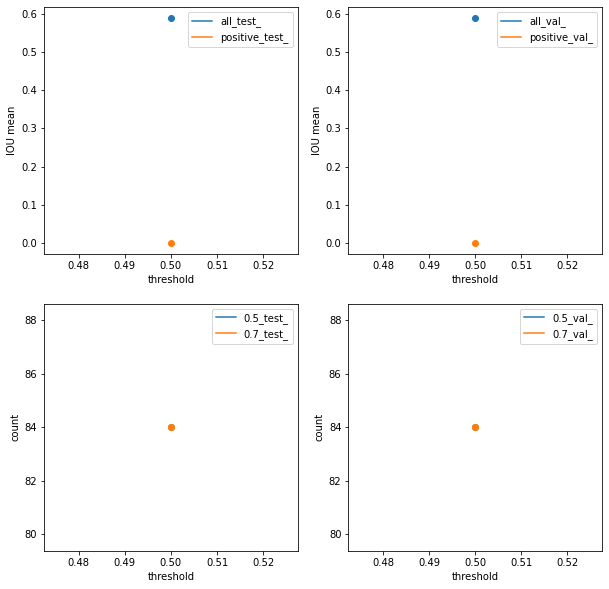

In [127]:
fig,(ax1,ax2) = plt.subplots(2,2,figsize=(10,10))



thresholds = [0.5]
test_value = ''

plot_threshold_mean = []
plot_threshold_mean_pos = []
plot_wrong_count = [] 
plot_label_count = []

i=0
for thresh in thresholds:
    

    test_resultcsv_path = os.path.join(result_parent_path,runname,f'_results{thresh*10}.csv').replace("\\",'/')
    val_resultcsv_path = os.path.join(result_parent_path,runname,f'_results{thresh*10}.csv').replace("\\",'/')


    test_df_result = pd.read_csv(test_resultcsv_path)
    val_df_result = pd.read_csv(val_resultcsv_path)
    
#     test_df_result.columns = ['prediction','IOu', 'ground_truth', 'fscore', 'img_name']
#     val_df_result.columns = ['prediction','fscore', 'ground_truth', 'IOU', 'img_name']

    test_wrong_df = test_df_result[(test_df_result['IOU'] < 0.5)].sort_values('IOU')
    val_wrong_df = val_df_result[(val_df_result['IOU'] < 0.5)].sort_values('IOU')

#     print(wrong_df)
#     print("thresh:",i,f'wrong count:{wrong_df.shape[0]} %{wrong_df.shape[0]/df_result.shape[0]*100//1}')
    plot_wrong_count.append([thresh,test_wrong_df.shape[0],test_df_result.IOU[(test_df_result['IOU'] < 0.7)].shape[0],
                            val_wrong_df.shape[0],val_df_result.IOU[(val_df_result['IOU'] < 0.7)].shape[0]])

    plot_threshold_mean.append([thresh,test_df_result.IOU.mean(),val_df_result.IOU.mean()])
    plot_threshold_mean_pos.append([thresh,test_df_result.IOU[test_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean(),val_df_result.IOU[val_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean()])
#     print('iou',df_result.IOU.mean(),'iou_positive:',df_result.IOU[df_result.ground_truth == True].mean())

    test_imgs = []
    for i in test_wrong_df.index:
        img = test_wrong_df.loc[i].img_name
        test_imgs.append(img)

    val_imgs = []
    for i in val_wrong_df.index:
        img = val_wrong_df.loc[i].img_name
        val_imgs.append(img)

    count_dict = dict.fromkeys(list(label_image_pair.keys()),[0,0])

#     img_dict = {}
    false_ls = []
    for i in test_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][0]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][0] = 1

    false_ls = []
    for i in val_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][1]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][1] = 1
#                 img_dict[l] = [i]

#     print('False classification: ',count_dict)
    plot_label_count.append([thresh,count_dict.copy()])
#     for l in np.sort(np.int32(list(count_dict.keys()))):
#         print(l,count_dict[str(l)]/5)
# df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
plot_threshold_mean = np.array(plot_threshold_mean)
plot_threshold_mean_pos = np.array(plot_threshold_mean_pos)
plot_wrong_count = np.array(plot_wrong_count)

print('plot_threshold_mean','\n\n',plot_threshold_mean, '\n\n','plot_threshold_mean_pos','\n\n',plot_threshold_mean_pos,'\n\n','plot_wrong_count','\n\n',plot_wrong_count)

#     plt.subplot(1,1)
ax1[0].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,1],label='all_test_'+test_value)
ax1[0].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1],label='positive_test_'+test_value)
ax1[0].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,1])
ax1[0].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1])

ax1[1].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,2],label='all_val_'+test_value)
ax1[1].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2],label='positive_val_'+test_value)
ax1[1].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,2])
ax1[1].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2])

for c in [0,1]:   
    ax1[c].legend()
    ax1[c].set_xlabel('threshold')
    ax1[c].set_ylabel('IOU mean')
#     ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

for c in [0,1]:   
    ax2[c].legend()
    ax2[c].set_xlabel('threshold')
    ax2[c].set_ylabel('count')
#     ax2[c].set_ylim(0,204)
plt.savefig('result.jpg')

In [92]:
test_df_result

,prediction,IOU,ground_truth,fscore,img_name
0,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,4
1,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,7
2,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,10
3,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,15
4,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,20
...,...,...,...,...,...
199,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.794688e-10,"0,0,0,0,0,0,0,0,0,0,1,1",0.757576,980
200,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.602821e-10,"0,1,0,0,1,1,0,0,0,1,0,0",0.533333,986
201,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",6.852600e-11,"0,0,1,1,0,0,0,0,0,1,0,1",0.533333,989
202,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.006543e-10,"0,0,0,0,0,1,1,0,0,1,0,1",0.533333,996


In [36]:
test_df_result.column

AttributeError: 'DataFrame' object has no attribute 'column'

FileNotFoundError: [Errno 2] File /home/woody/iwfa/iwfa024h/results/PA_M/FS280_BEST/c/TEST/results1.0.csv does not exist: '/home/woody/iwfa/iwfa024h/results/PA_M/FS280_BEST/c/TEST/results1.0.csv'

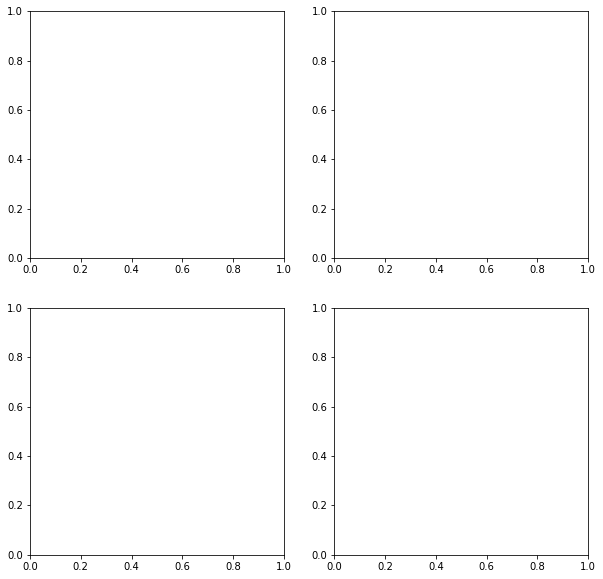

In [37]:

fig,(ax1,ax2) = plt.subplots(2,2,figsize=(10,10))

for test_value in test_vals_list:

# #     print(test_value)
#     result_parent_path =  "E:/AI/FAPS/code/results/PA_M"
#     if test_val !='c':
#         resultcsv_paths = glob.glob(os.path.join(result_parent_path,runname,testname,'resul*.csv'))
# #         print('here')
#     else:
#         resultcsv_paths = glob.glob(os.path.join(result_parent_path,runname,testname,test_value,'resul*.csv'))
#     print(resultcsv_paths)
    thresholds = [0.1,0.2,0.3,0.4,0.5]

    plot_threshold_mean = []
    plot_threshold_mean_pos = []
    plot_wrong_count = [] 
    plot_label_count = []

    

    i=0
    for thresh in thresholds:
        
        if testname == 'NORMAL':
            test_resultcsv_path = os.path.join(result_parent_path,runname,testname,'TEST',f'results{thresh*10}.csv').replace("\\",'/')
            val_resultcsv_path = os.path.join(result_parent_path,runname,testname,'VAL',f'results{thresh*10}.csv').replace("\\",'/')

        else:
            test_resultcsv_path = os.path.join(result_parent_path,runname,testname,test_value,'TEST',f'results{thresh*10}.csv').replace("\\",'/')
            val_resultcsv_path = os.path.join(result_parent_path,runname,testname,test_value,'VAL',f'results{thresh*10}.csv').replace("\\",'/')
        
        test_df_result = pd.read_csv(test_resultcsv_path)
        val_df_result = pd.read_csv(val_resultcsv_path)

        test_wrong_df = test_df_result[(test_df_result['IOU'] < 0.5)].sort_values('IOU')
        val_wrong_df = val_df_result[(val_df_result['IOU'] < 0.5)].sort_values('IOU')

    #     print(wrong_df)
    #     print("thresh:",i,f'wrong count:{wrong_df.shape[0]} %{wrong_df.shape[0]/df_result.shape[0]*100//1}')
        plot_wrong_count.append([thresh,test_wrong_df.shape[0],test_df_result.IOU[(test_df_result['IOU'] < 0.7)].shape[0],
                                val_wrong_df.shape[0],val_df_result.IOU[(val_df_result['IOU'] < 0.7)].shape[0]])

        plot_threshold_mean.append([thresh,test_df_result.IOU.mean(),val_df_result.IOU.mean()])
        plot_threshold_mean_pos.append([thresh,test_df_result.IOU[test_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean(),val_df_result.IOU[val_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean()])
    #     print('iou',df_result.IOU.mean(),'iou_positive:',df_result.IOU[df_result.ground_truth == True].mean())

        test_imgs = []
        for i in test_wrong_df.index:
            img = test_wrong_df.loc[i].img_name
            test_imgs.append(img)

        val_imgs = []
        for i in val_wrong_df.index:
            img = val_wrong_df.loc[i].img_name
            val_imgs.append(img)

        count_dict = dict.fromkeys(list(label_image_pair.keys()),[0,0])

    #     img_dict = {}
        false_ls = []
        for i in test_imgs:
            if i not in image_label_pair.keys():
                continue
            for l in image_label_pair[i]:
                false_ls.append(int(l))
                if l in count_dict.keys():
                    count_dict[l][0]+=1
    #                 img_dict[l].append(i)
                else:
                    count_dict[l][0] = 1

        false_ls = []
        for i in val_imgs:
            if i not in image_label_pair.keys():
                continue
            for l in image_label_pair[i]:
                false_ls.append(int(l))
                if l in count_dict.keys():
                    count_dict[l][1]+=1
    #                 img_dict[l].append(i)
                else:
                    count_dict[l][1] = 1
    #                 img_dict[l] = [i]

    #     print('False classification: ',count_dict)
        plot_label_count.append([thresh,count_dict.copy()])
    #     for l in np.sort(np.int32(list(count_dict.keys()))):
    #         print(l,count_dict[str(l)]/5)
    # df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    plot_threshold_mean = np.array(plot_threshold_mean)
    plot_threshold_mean_pos = np.array(plot_threshold_mean_pos)
    plot_wrong_count = np.array(plot_wrong_count)

    print('plot_threshold_mean','\n\n',plot_threshold_mean, '\n\n','plot_threshold_mean_pos','\n\n',plot_threshold_mean_pos,'\n\n','plot_wrong_count','\n\n',plot_wrong_count)

#     plt.subplot(1,1)
    ax1[0].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,1],label='all_test_'+test_value)
    ax1[0].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1],label='positive_test_'+test_value)
    ax1[0].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,1])
    ax1[0].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1])
    
    ax1[1].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,2],label='all_val_'+test_value)
    ax1[1].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2],label='positive_val_'+test_value)
    ax1[1].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,2])
    ax1[1].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2])

    for c in [0,1]:   
        ax1[c].legend()
        ax1[c].set_xlabel('threshold')
        ax1[c].set_ylabel('IOU mean')
#         ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
    ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_test_'+test_value)
    ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
    ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_test_'+test_value)
    ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

    ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val_'+test_value)
    ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
    ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val_'+test_value)
    ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

    for c in [0,1]:   
        ax2[c].legend()
        ax2[c].set_xlabel('threshold')
        ax2[c].set_ylabel('count')
#         ax2[c].set_ylim(0,204)
    plt.savefig('result.jpg')

In [48]:
test_df_result.shape

(204, 5)

TypeError: list indices must be integers or slices, not tuple

[[21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]]
[[18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]]
[[23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]]


(0.0, 30.0)

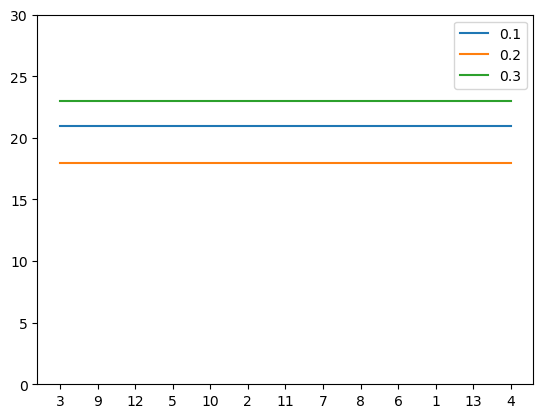

In [50]:
for i,count in plot_label_count[:-2]:
    print(np.array(list(count.values())))
    plt.plot(list(count.keys()), np.array(list(count.values()))[:,0],label=i)
#     plt.scatter(list(count.keys()), list(count.values()),label=i)
plt.legend()
plt.ylim(0,30)

In [343]:

img_dict

False classification:  {'5': 5, '6': 2, '2': 3, '13': 3, '3': 3, '11': 2, '10': 1, '8': 1}


{'5': [948, 985, 994, 993, 700],
 '6': [948, 985],
 '2': [948, 985, 637],
 '13': [985, 994, 993],
 '3': [994, 993, 700],
 '11': [994, 993],
 '10': [994],
 '8': [993]}

2 0.6
3 0.6
5 1.0
6 0.4
8 0.2
10 0.2
11 0.4
13 0.6


(0.0, 5.0)

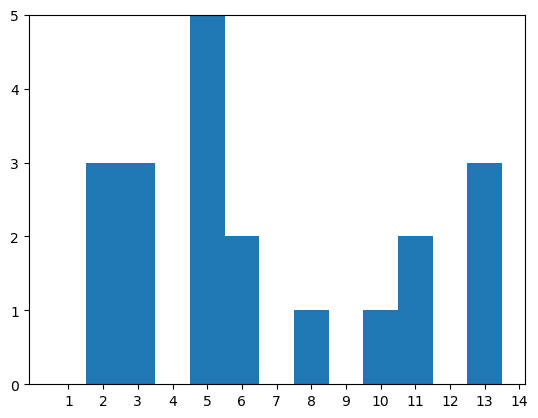

In [334]:
plt.hist(false_ls,bins=np.arange(0.5,14.5,1))
plt.xticks(np.arange(1,15))
plt.ylim(0,5)

In [95]:
with open(f'splits/PA/split_16.pyb', "rb") as f:
    _,_,train_seg_path,test_seg_path,_,_ = pickle.load(f)

In [98]:
count_dict = {}
for img in train_seg_path:
    i = os.path.basename(os.path.normpath(img))
    i = int(i[:-4])
    if i not in image_label_pair.keys():
        continue
    for l in image_label_pair[i]:
        if l in count_dict.keys():
            count_dict[l]+=1
        else:
            count_dict[l] = 1
print('train segmenation count: ',count_dict)   

train segmenation count:  {'4': 4, '13': 6, '9': 3, '12': 6, '3': 11, '10': 1, '8': 2, '5': 1, '7': 1, '11': 2, '6': 1, '2': 1}


In [99]:
count_dict = {}
for img in test_seg_path:
    i = os.path.basename(os.path.normpath(img))
    i = int(i[:-4])
    if i not in image_label_pair.keys():
        continue
    for l in image_label_pair[i]:
        if l in count_dict.keys():
            count_dict[l]+=1
        else:
            count_dict[l] = 1
print('test segmenation count: ',count_dict)  

test segmenation count:  {'11': 9, '13': 12, '3': 64, '12': 13, '8': 10, '7': 16, '10': 15, '4': 14, '9': 15, '6': 13, '1': 11, '5': 6, '2': 8}


In [ ]:
result_parent_path =  "E:/AI/FAPS/code/Mixedsupervision/results/KSDD2"
test_paths = ['N_246','N_126','N_53','N_16','N_0']
for testname in test_paths:
    resultcsv_path = os.path.join(result_parent_path,testname,'results.csv').replace("\\",'/')
    df_result = pd.read_csv(resultcsv_path)
    df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    
    print(testname,f1_score(df_result.ground_truth,df_result.decision),precision_score(df_result.ground_truth,df_result.decision),recall_score(df_result.ground_truth,df_result.decision))
    wrong_df = df_result.loc[df_result['decision'] != df_result['ground_truth'],:]

In [481]:
data = {
    ('A', 'X'): [1, 2, 3],
    ('A', 'Y'): [4, 5, 6],
    ('B', 'X'): [7, 8, 9],
    ('B', 'Y'): [10, 11, 12]
}
df = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(data.keys()))

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Remove column at the second level
df = df.drop('X', axis=1, level=1)

# Display the modified DataFrame
print("\nDataFrame after removing column at the second level:")
print(df)

Original DataFrame:
   A     B    
   X  Y  X   Y
0  1  4  7  10
1  2  5  8  11
2  3  6  9  12

DataFrame after removing column at the second level:
   A   B
   Y   Y
0  4  10
1  5  11
2  6  12


In [ ]:
result_parent_path =  "E:/AI/FAPS/code/Mixedsupervision/results/PA"
test_paths = ['WS288','WS126','WS53','WS16 - Copy','WS0 - Copy']
for testname in test_paths:
    resultcsv_path = os.path.join(result_parent_path,testname,'results.csv').replace("\\",'/')
    df_result = pd.read_csv(resultcsv_path)
    df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    
    print(testname,f1_score(df_result.ground_truth,df_result.decision),precision_score(df_result.ground_truth,df_result.decision),recall_score(df_result.ground_truth,df_result.decision))
    wrong_df = df_result.loc[df_result['decision'] != df_result['ground_truth'],:]